In [84]:
import networks as n
import networkx as nx
from collections import OrderedDict
from collections import Counter
import math
import matplotlib.pyplot as plt
from adjustText import adjust_text
from termcolor import cprint
import numpy as np

In [3]:
ds = n.load_feather()
projectToDomainDs = n.load_projectToDomainCsv()
projects_list = n.create_project_list(ds, projectToDomainDs)
authors_list = n.create_authors_list(projects_list)

In [5]:
ds.columns

Index(['orig_index', 'Nom de l'objet', 'Programme', 'Adresse 1', 'Adresse 2',
       'Adresse 3', 'Numéro postal', 'Localité', 'Canton - Département',
       'Pays', 'Date de début de l'objet', 'Date de fin de l'objet',
       'Concours ouvert à', 'Notes de l'objet', 'Auteurs', 'Rôle de l'auteur',
       'Dossiers reliés', 'Pièces reliées', 'CombinedArtists', 'is_jury',
       'paired_competitons', 'comp_id', 'Commune', 'Canton', 'geo_loc',
       'Auteurs_cleaned'],
      dtype='object')

In [112]:
def shannon_entropy(counts: Counter[str]) -> float:
    """Compute Shannon entropy from a Counter of region frequencies."""
    total = sum(counts.values())
    if total == 0:
        return 0.0
    entropy = 0.0
    for count in counts.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def compute_entropy_per_author(authors: list[n.Author], mergeGEandVD = False) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        canton_counts = Counter(project.canton if (not mergeGEandVD) or (project.canton != "GE" and project.canton != "VD") else "GE or VD"  for project in author.projects)
        entropy = shannon_entropy(canton_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def compute_domain_entropy_per_author(authors: list[n.Author]) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        domain_counts = Counter(project.domain for project in author.projects)
        entropy = shannon_entropy(domain_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def get_maxdomain(author: n.Author) -> str:
    domains = {}
    for project in author.projects:
        domains[project.domain] = domains.get(project.domain, 0) + 1
    max_domain = max(domains, key=domains.get)
    return max_domain

def get_year_and_maxcanton(author: n.Author, mergeGEandVD = False):
    mean_year = 0
    year_count = 0
    for project in author.projects:
        if project.year < 2000:
            mean_year += project.year
            year_count += 1
    mean_year = (mean_year / year_count) if year_count else 2020

    cantons = {}
    for project in author.projects:
        if mergeGEandVD and (project.canton == "GE" or project.canton == "VD"):
            cantons["GE or VD"] = cantons.get("GE or VD", 0) + 1
        else:
            cantons[project.canton] = cantons.get(project.canton, 0) + 1
    max_canton = max(cantons, key=cantons.get)

    return mean_year, max_canton

# Plotting function
def plot_entropy_vs_birth(authors: list[n.Author], on="canton", mergeGEandVD = False, pdffilename=None, pagerank_dict=None):
    if on == "canton":
        entropy_map = compute_entropy_per_author(authors, mergeGEandVD)
    elif on == "domain":
        entropy_map = compute_domain_entropy_per_author(authors)
    else:
        raise ValueError("On must be 'canton' or 'domain'")
    if pagerank_dict is None:
        authors = [author for author in authors if len(author.projects) > 13] # was 5
        sizes = [max(30, len(author.projects) * 8) for author in authors]  # Scale bubble size
    else:
        authors = [author for author in authors if pagerank_dict[author.name_abr] > 6.5]
        sizes = [pagerank_dict[author.name_abr] * 30 for author in authors]  # Scale bubble size
    y = [entropy_map[author.name_abr] for author in authors]
    x = [get_year_and_maxcanton(author, mergeGEandVD)[0] for author in authors]
    colors = [get_year_and_maxcanton(author, mergeGEandVD)[1] if on == "canton" else get_maxdomain(author) for author in authors]
    labels = [author.name_abr for author in authors]

    # Assign colors
    unique_regions = list(set(colors))
    region_colors = {region: f"C{idx}" for idx, region in enumerate(unique_regions)}
    color_values = [region_colors[region] for region in colors]

    plt.figure(figsize=(6,4)) # 12, 7
    scatter = plt.scatter(x, y, s=sizes, c=color_values, alpha=0.7, edgecolor='black')

    #Add labels near bubbles
    # for i, label in enumerate(labels):
    #     if len(authors[i].projects) > 16:
    #         plt.text(x[i] + 0.02, y[i], label, fontsize=9)
    
    # Use adjustText to place labels
    text_objects = [
        plt.text(x[i], y[i], labels[i], fontsize=12)
        for i in range(len(authors))  if (pagerank_dict and pagerank_dict[authors_list[i].name_abr] > 6.5) or len(authors[i].projects) > 20 # len was 13
    ]
    adjust_text(text_objects, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-',  color='grey', lw=2.0), min_arrow_length=1) #lw=0.5

    # Custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=region[:10],
                          markerfacecolor=color, markersize=10)
               for region, color in region_colors.items()]
    plt.legend(handles=handles, title=f"Max {on}")

    plt.ylabel(f"Shannon Entropy ({on.title()} Diversity)")
    #plt.ylim(1.8, 3.1)
    plt.xlabel("Mean Year")
    if pagerank_dict is None:
        plt.title("Architect Entropy: bubble size is number of projects by that architect")
    else:
        plt.title("Architect Entropy: bubble size is pagerank of that architect")
    plt.grid(True)
    plt.tight_layout()
    if pdffilename is not None:
        plt.savefig(pdffilename)

    plt.show()


- laverrière, alphonse: né Carrouge (GE), mort Lausanne (VD)
- thévenaz, charles: Bullet et Lausanne (VD)
- epitaux, georges: Lausanne (VD)
- boschetti, fonso: né à Vezio (TI), Lausanne

- prince, ernest: Neuchâtel (NE)
morisod, paul: Sion (VS)

In [5]:
authors_list = sorted(authors_list, key=lambda author: len(author.projects), reverse=True)
for author in authors_list:
    if len(author.projects) <= 10:
        continue
    cantons = {}
    for project in author.projects:
        cantons[project.canton] = cantons.get(project.canton, 0) + 1
    cantons = OrderedDict(sorted(cantons.items(), key=lambda item: item[1], reverse=True))
    max_canton = next(iter(cantons.items()))
    print(f"{author.name_abr}: {max_canton[0]}: {max_canton[1]}/{len(author.projects)} or {round((max_canton[1]/len(author.projects))*100, 2)}%")

laverrière, alphonse: VD: 34/45 or 75.56%
thévenaz, charles: VD: 27/41 or 65.85%
epitaux, georges: VD: 32/40 or 80.0%
béguin, jean: NE: 14/29 or 48.28%
boschetti, fonso: VD: 21/29 or 72.41%
prince, ernest: NE: 16/26 or 61.54%
piccard, marc: VD: 16/23 or 69.57%
morisod, paul: VS: 20/23 or 86.96%
brugger, frédéric: VD: 17/22 or 77.27%
monod, eugène: VD: 15/22 or 68.18%
schorp, alphonse: VD: 21/22 or 95.45%
mamin, eugène: VD: 18/21 or 85.71%
convert, robert: NE: 12/21 or 57.14%
luscher, rodolphe: VD: 18/21 or 85.71%
furrer, edouard: VS: 17/20 or 85.0%
brugger, charles: VD: 18/20 or 90.0%
meyer, henri: VD: 14/20 or 70.0%
lonchamp, jacques: VD: 14/19 or 73.68%
braillard, maurice: GE: 7/19 or 36.84%
regamey, jaques: VD: 14/17 or 82.35%
hoechel, arnold: GE: 13/17 or 76.47%
brera, georges: GE: 12/16 or 75.0%
perrelet, jean: VD: 8/16 or 50.0%
lozeron, arthur: GE: 10/15 or 66.67%
kyburz, jean: VS: 6/15 or 40.0%
froidevaux, rené: VD: 10/15 or 66.67%
torcapel, john: GE: 13/15 or 86.67%
favarger, j

In [8]:
entropies = compute_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author laverrière, alphonse: Entropy = 1.259
Author thévenaz, charles: Entropy = 1.683
Author epitaux, georges: Entropy = 1.153
Author boschetti, fonso: Entropy = 1.333
Author béguin, jean: Entropy = 2.028
Author prince, ernest: Entropy = 1.748
Author piccard, marc: Entropy = 1.534
Author morisod, paul: Entropy = 0.678
Author schorp, alphonse: Entropy = 0.267
Author monod, eugène: Entropy = 1.580
Author brugger, frédéric: Entropy = 1.301
Author convert, robert: Entropy = 1.791
Author mamin, eugène: Entropy = 0.818
Author luscher, rodolphe: Entropy = 0.818
Author brugger, charles: Entropy = 0.569
Author furrer, edouard: Entropy = 0.748
Author meyer, henri: Entropy = 1.457
Author braillard, maurice: Entropy = 2.076
Author lonchamp, jacques: Entropy = 1.337
Author regamey, jaques: Entropy = 0.834
Author hoechel, arnold: Entropy = 1.140
Author brera, georges: Entropy = 1.311
Author perrelet, jean: Entropy = 2.078
Author kyburz, jean: Entropy = 1.566
Author torcapel, john: Entropy = 0.700
A

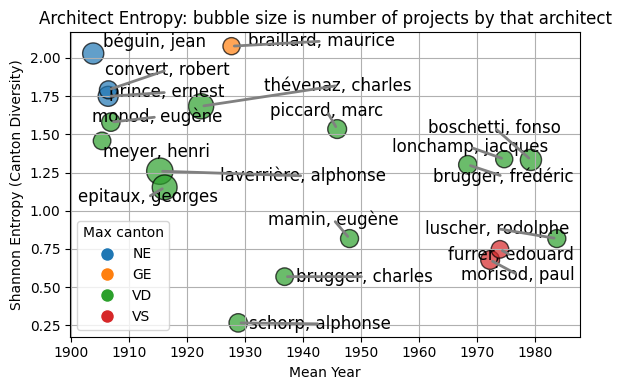

In [95]:
plot_entropy_vs_birth(authors_list, pdffilename="architect_canton_entropy_2.pdf")

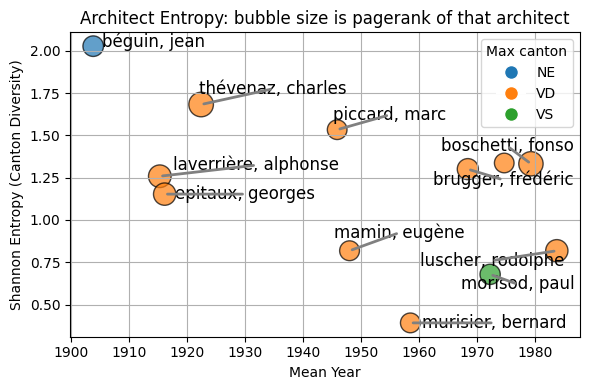

In [ ]:
# First execute the cells further down that create the pagerank_dict before executing this cell
plot_entropy_vs_birth(authors_list, pdffilename="architect_canton_entropy_pagerank.pdf", pagerank_dict=pagerank_dict)

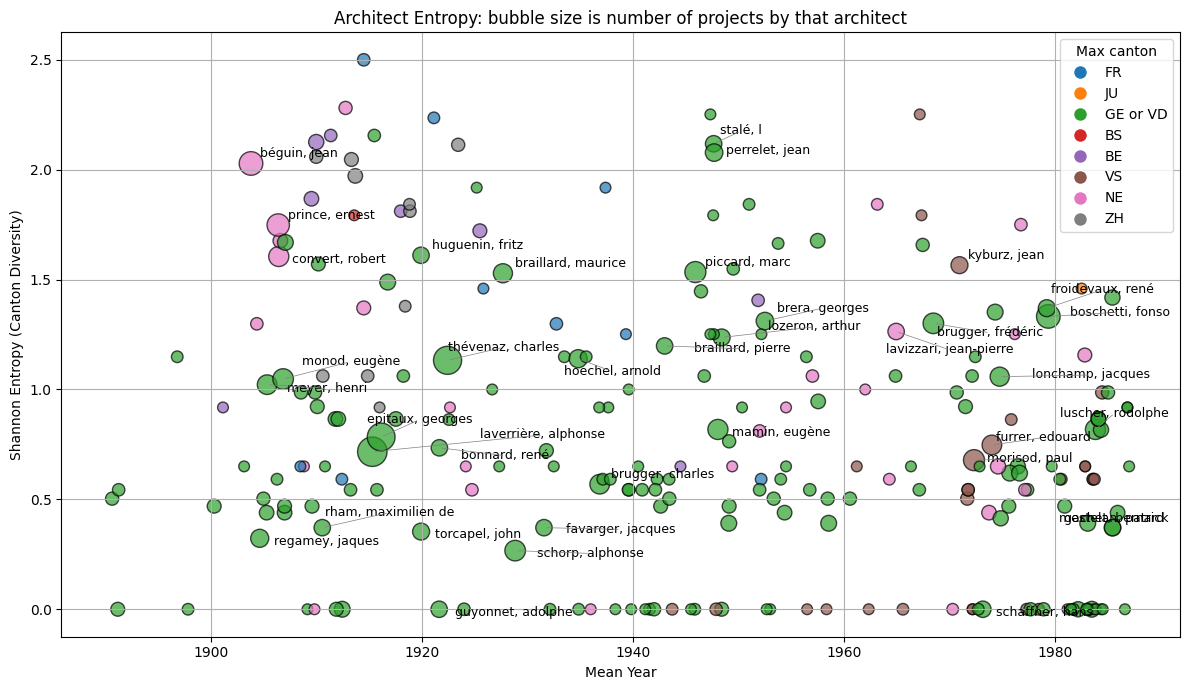

In [26]:
plot_entropy_vs_birth(authors_list, mergeGEandVD=True)

## Domain entropy

In [12]:
authors_list[0].projects

frozenset({Project(name='Concours pour un centre administratif à Cortaillod, jugement', authors_abr=frozenset({'bader, michel', 'blanc, pierre', 'rollier, claude', 'marti, daniel', 'maye, etienne', 'favre, sandra', 'maye, laurent'}), year=1992, authors_to_role=frozendict.frozendict({'blanc, pierre': '2e prix', 'rollier, claude': 'Achat', 'bader, michel': '3e prix', 'marti, daniel': '3e prix', 'favre, sandra': '3e prix', 'maye, laurent': '1er  prix', 'maye, etienne': '1er  prix'}), canton='NE', domain='')})

In [19]:
entropies = compute_domain_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author rossé, p.-a: Entropy = 0.000
Author studer, c: Entropy = 0.000
Author leuenberger, daniel: Entropy = 1.585
Author heusler, jean-marc: Entropy = 1.585
Author volpato, r: Entropy = 0.000
Author langel, ph: Entropy = 0.000
Author mueller, jean: Entropy = 1.000
Author ackermann, jean-claude: Entropy = 1.000
Author theubet, j: Entropy = 0.000
Author schaffter, v: Entropy = 0.000
Author chavanne, etienne: Entropy = 1.585
Author tschumi, alain-g: Entropy = 1.522
Author bart, o: Entropy = 0.000
Author boillat, j.-m: Entropy = 0.000
Author blaser, r: Entropy = 0.000
Author gerster, giuseppe: Entropy = 1.000
Author chevillat, christiane: Entropy = 0.000
Author sanglard, v: Entropy = 0.000
Author rossel, sandrine: Entropy = 0.000
Author stékoffer, n: Entropy = 0.000
Author eschmann, marcel: Entropy = 1.918
Author ramseyer, e: Entropy = 0.000
Author chevillat, jean-claude: Entropy = 1.000
Author sironi, roméo: Entropy = 0.000
Author freudenreich, jacques de: Entropy = 0.000
Author chappuis,

In [25]:
for author in authors_list:
    if author.name_abr == "laverrière, alphonse" or author.name_abr == "lavizzari, jean-pierre" or author.name_abr == "boschetti, fonso" or author.name_abr.find("wagner") != -1:
        cprint(author.name_abr, "green")
        for project in author.projects:
            print(f"{project.domain}: {project.name}")

boschetti, fonso
Residential: Concours pour des logements à Yverdon-les-Bains, jugement
Education: Concours pour un Gymnase et Ecole supérieure de commerce à Nyon, jugement
Public / Civic: Concours pour un centre scolaire à Lucens, jugement
Public / Civic: Concours pour les Archives cantonales vaudoises, jugement
Sports & Leisure: Concours pour le CESSNOV à Yverdon, jugement
Public / Civic: Concours pour le nouveau bâtiment "La Poste" à Rivaz, jugement
Public / Civic: Concours pour des bâtiments publics à Aran-Villette, jugement
Infrastructure: Concours pour l'ilôt Riponne-Tunnel à Lausanne, jugement
Public / Civic: Concours pour la Station fédérale de recherches agronomiques à Changins, jugement
Sports & Leisure: Concours d'idées pour un Centre sportif polyvalent à Verbier, jugement
Residential: Concours pour la maison d'arrêts et de préventive de la Côte, jugement
Public / Civic: Concours pour le nouveau tribunal cantonal de l'Hermitage à Lausanne, jugement
Education: Concours d'idée

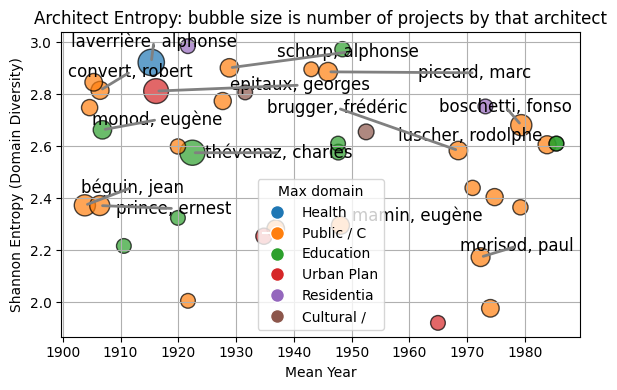

In [113]:
plot_entropy_vs_birth(authors_list, on="domain", pdffilename="architect_domain_entropy.pdf")

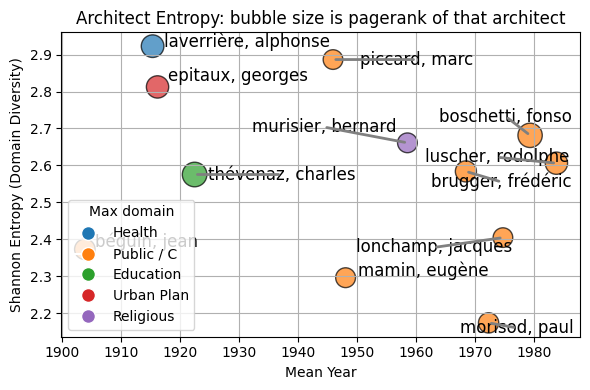

In [88]:
plot_entropy_vs_birth(authors_list, on="domain", pdffilename="architect_domain_entropy_pagerank.pdf", pagerank_dict=pagerank_dict)

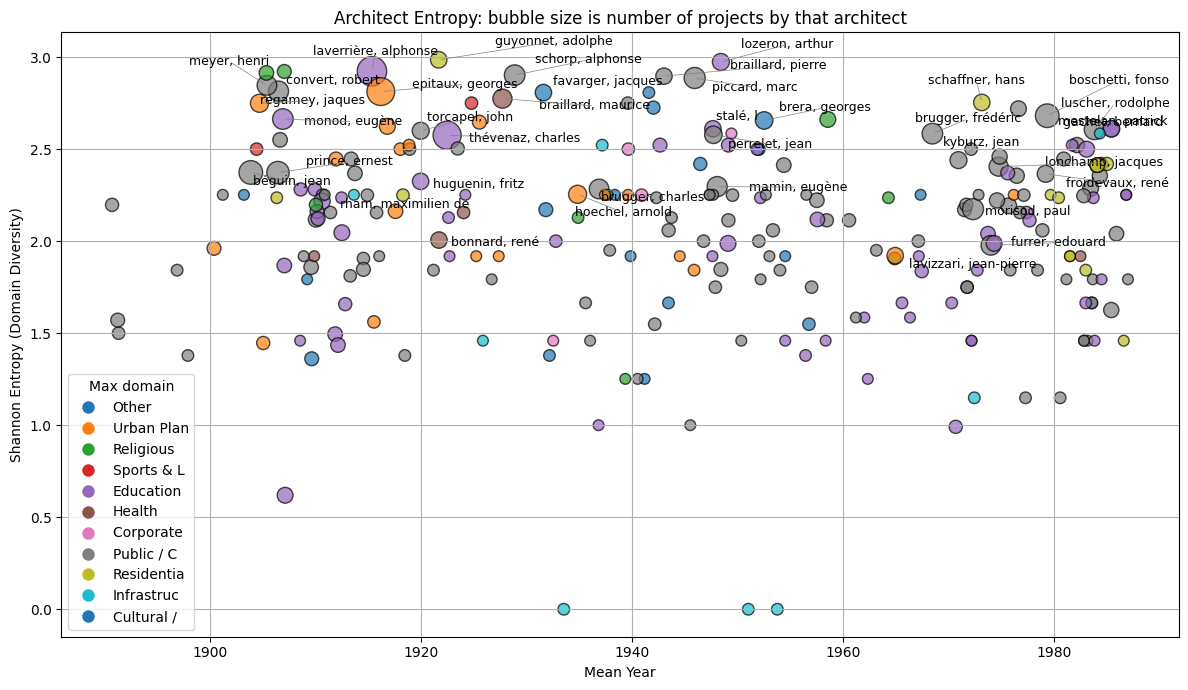

In [18]:
plot_entropy_vs_birth(authors_list, on="domain")

In [20]:
ds[ds["Canton"].apply(lambda s: s if isinstance(s, str) else "unknown").str.startswith("& ")]

,orig_index,Nom de l'objet,Programme,Adresse 1,Adresse 2,Adresse 3,Numéro postal,Localité,Canton - Département,Pays,...,Dossiers reliés,Pièces reliées,CombinedArtists,is_jury,paired_competitons,comp_id,Commune,Canton,geo_loc,Auteurs_cleaned
83,301,Concours pour des abris de protection antiaéri...,None,None,None,None,NaN,None,None,None,...,None,None,"[[Gander, P], [Berthod, L.], [Forster, H, AG],...",True,[],301,& C:/Users/ASUS/AppData/Local/Programs/Python/...,& C:/Users/ASUS/AppData/Local/Programs/Python/...,None,"[Gander, P, Berthod, L., Forster, H, AG, Thürl..."


In [23]:
ds["Commune"].unique()

array(['Vevey', 'France', 'Genève', 'Le Locle', 'Neuchâtel', 'Lausanne',
       None, 'Yverdon-les-Bains', 'USA', 'Payerne', 'La Tour-de-Peilz',
       'Zürich', 'Bellinzona', 'Herisau', 'Czechia', 'Lauenen b. Gstaad',
       'Chancy', 'Basel', 'Colombier NE', 'Bern', 'Solothurn', 'Leysin',
       'Alle', 'Sion', 'Zofingen', 'Montreux', 'Fribourg', 'Biel/Bienne',
       'Belgique', 'Epesses', 'Schlieren', 'Ascona', 'Grenchen',
       '& C:/Users/ASUS/AppData/Local/Programs/Python/Python313/python.exe c:/Users/ASUS/Programmation/SwissArchitectureCompetitions/check_communes.py',
       'Caux', 'Cologny', 'Visp', 'Morges', 'Clarens', 'Orges',
       'Avenches', 'Bermgarten AG', 'Locarno', 'Pully', 'Hérémence',
       'Pregassona', 'La Chaux-de-Fonds', 'Echandens', 'Fiesch',
       'Chêne-Bourg', 'La Tour-de-Trême', 'Delémont', 'Lucens', 'Nyon',
       'Martigny', 'Japan', 'Riddes', 'Mission', 'Ettenhausen',
       'Liebefeld', 'Aigle', 'Wabern', 'Moudon', 'Italy', '', 'Gampel',
       'Li

In [24]:
ds["Canton"].unique()

array(['VD', 'France', 'GE', 'NE', None, 'USA', 'ZH', 'TI', 'AR',
       'Czechia', 'BE', 'BS', 'SO', 'Alle', 'VS', 'AG', 'FR', 'Belgique',
       '& C:/Users/ASUS/AppData/Local/Programs/Python/Python313/python.exe c:/Users/ASUS/Programmation/SwissArchitectureCompetitions/check_communes.py',
       'Bermgarten AG', 'JU', 'Japan', 'Ettenhausen', 'Italy', '', 'BL',
       'VVilleneuve VD', 'GR', 'GL', 'SZ', 'LU', 'Le Vaud', 'SH', 'Glis',
       'Tunisia', 'Bulgaria'], dtype=object)

In [6]:
graph = n.create_authors_network(authors_list)
pr = nx.pagerank(graph)

  0%|          | 0/4014 [00:00<?, ?it/s]

100%|██████████| 4014/4014 [00:09<00:00, 427.84it/s] 


In [87]:
graph_weighted_degrees = [deg for _, deg in graph.degree(weight='weight')]
np.std(graph_weighted_degrees)

np.float64(39.3813680662035)

In [90]:
for i in range(100):
    print(f"{authors_list[i].name_abr}, {len(authors_list[i].projects)} projects")

laverrière, alphonse, 45 projects
thévenaz, charles, 41 projects
epitaux, georges, 40 projects
béguin, jean, 29 projects
boschetti, fonso, 29 projects
prince, ernest, 26 projects
piccard, marc, 23 projects
morisod, paul, 23 projects
brugger, frédéric, 22 projects
monod, eugène, 22 projects
schorp, alphonse, 22 projects
mamin, eugène, 21 projects
convert, robert, 21 projects
luscher, rodolphe, 21 projects
furrer, edouard, 20 projects
brugger, charles, 20 projects
meyer, henri, 20 projects
lonchamp, jacques, 19 projects
braillard, maurice, 19 projects
regamey, jaques, 17 projects
hoechel, arnold, 17 projects
brera, georges, 16 projects
perrelet, jean, 16 projects
lozeron, arthur, 15 projects
kyburz, jean, 15 projects
froidevaux, rené, 15 projects
torcapel, john, 15 projects
favarger, jacques, 14 projects
lavizzari, jean-pierre, 14 projects
schaffner, hans, 14 projects
huguenin, fritz, 14 projects
mestelan, patrick, 14 projects
gachet, bernard, 14 projects
guyonnet, adolphe, 14 projects
b

In [ ]:
pagerank_list = sorted(pr.items(), key=lambda x: x[1], reverse=True)
pagerank_values = [pr for _, pr in pagerank_list]
mean = np.mean(pagerank_values)
std = np.std(pagerank_values)
zscore_pageranks = [(id, (pr - mean) / std) for id, pr in pagerank_list]
pagerank_dict = {identifier: score for identifier, score in zscore_pageranks}
zscore_pageranks

[('thévenaz, charles', np.float64(10.450445299881046)),
 ('boschetti, fonso', np.float64(10.233260860417817)),
 ('laverrière, alphonse', np.float64(8.846878379882382)),
 ('epitaux, georges', np.float64(8.617708256370317)),
 ('luscher, rodolphe', np.float64(8.580126839125423)),
 ('brugger, frédéric', np.float64(7.688087132975412)),
 ('béguin, jean', np.float64(7.301418274914301)),
 ('morisod, paul', np.float64(7.098461271278919)),
 ('mamin, eugène', np.float64(6.792289608839439)),
 ('murisier, bernard', np.float64(6.74583033155361)),
 ('piccard, marc', np.float64(6.684498482846558)),
 ('lonchamp, jacques', np.float64(6.656133733132693)),
 ('kolecek, ivan', np.float64(6.415455265874562)),
 ('musy, eric', np.float64(6.367733235297117)),
 ('mestelan, patrick', np.float64(6.3306055054203805)),
 ('gachet, bernard', np.float64(6.3306055054203805)),
 ('prince, ernest', np.float64(6.21365987018848)),
 ('hauenstein, eric', np.float64(6.1734853457709455)),
 ('furrer, edouard', np.float64(6.171482

## Filter for authors graph created with gephi

In [10]:
def author_names(G: nx.Graph):
    # Step 1: Filter nodes where 'nb_projects' > 1
    nodes_to_keep = [n for n, attr in G.nodes(data=True) if attr.get('nb_projects', 0) > 1]

    # Step 2: Create subgraph with these nodes
    H = G.subgraph(nodes_to_keep).copy()

    # Step 3: Remove edges with weight <= 1
    edges_to_remove = [(u, v) for u, v, attr in H.edges(data=True) if attr.get('weight', 0) <= 1]
    H.remove_edges_from(edges_to_remove)

    # Step 4: Keep only the largest connected component
    largest_cc = max(nx.connected_components(H), key=len)

    H_largest = H.subgraph(largest_cc).copy()

    # Step 5: Return the IDs of the remaining authors
    remaining_author_ids = list(H_largest.nodes())

    print("Remaining Author IDs:", len(remaining_author_ids))
    return remaining_author_ids


def filter_dataset(authors_list):
    remaining_author_ids = author_names(graph)
    authors_filtered = [author for author in authors_list if author.name_abr in remaining_author_ids]
    print("Remaining Authors:", len(authors_filtered))
    return authors_filtered

authors_filtered = filter_dataset(authors_list)


Remaining Author IDs: 867
Remaining Authors: 867


In [12]:
def mean_percentage_in_maxcanton(authors: list[n.Author]):
    nb_projects = 0
    nb_maxcanton = 0
    for author in authors:
        cantons = {}
        for project in author.projects:
            cantons[project.canton] = cantons.get(project.canton, 0) + 1
        max_canton = max(cantons, key=cantons.get)
        nb_maxcanton += cantons[max_canton]
        nb_projects += len(author.projects)
    return nb_maxcanton / nb_projects

print(mean_percentage_in_maxcanton(authors_filtered))
print(mean_percentage_in_maxcanton(authors_list))


0.7791695662259337
0.839191022320878
